In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

try:
    import cplex
    from cplex.exceptions import CplexError
except: 
    print("Warning: Cplex not found.")
import math

In [ ]:
# Initialize the problem by defining the parameters
n = 3  # number of nodes + depot (n+1)
K = 2  # number of vehicles

In [ ]:
class Initializer():

    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [ ]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()

In [ ]:
class ClassicalOptimizer:

    def __init__(self, instance,n,K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles


    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n-self.K)


    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0])+[0. for x in range(0,n-1)]
        my_ub = [1 for x in range(0,n**2+n-1)]
        my_lb = [0 for x in range(0,n**2)] + [0.1 for x in range(0,n-1)]
        my_ctype = "".join(['I' for x in range(0,n**2)]) + "".join(['C' for x in range(0,n-1)])

        my_rhs = 2*([K] + [1 for x in range(0,n-1)]) + [1-0.1 for x in range(0,(n-1)**2-(n-1))] + [0 for x in range(0,n)]
        my_sense = "".join(['E' for x in range(0,2*n)]) + "".join(['L' for x in range(0,(n-1)**2-(n-1))])+"".join(['E' for x in range(0,n)])

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x,cost
    

    def populatebyrow(self,prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs):

        n = self.n
    
        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj = my_obj, lb = my_lb, ub = my_ub, types = my_ctype)
    
        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0,n):
            col = [x for x in range(0+n*ii,n+n*ii)]
            coef = [1 for x in range(0,n)]
            rows.append([col, coef])

        for ii in range(0,n):
            col = [x for x in range(0+ii,n**2,n)]
            coef = [1 for x in range(0,n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0,n):
                if (ii != jj)and(ii*jj>0):

                    col = [ii+(jj*n), n**2+ii-1, n**2+jj-1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0,n):
            col = [(ii)*(n+1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [ ]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance,n,K)

# Print number of feasible solutions
print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

Number of feasible solutions = 3.0


In [ ]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x,classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
    # Print the solution
    print(z)
except: 
    print("CPLEX may be missing.")

[1.0, 1.0, 1.0, 0.0, 1.0, 0.0]


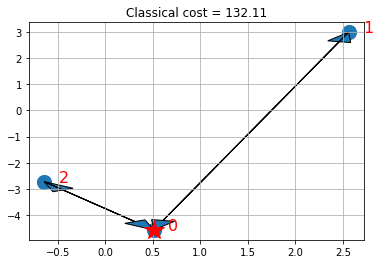

In [ ]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()    

if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

In [ ]:
%%time
# Initialize the problem by defining the parameters
n = 5  # number of nodes + depot (n+1)
K = 3  # number of vehicles

# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()

# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance,n,K)

# Print number of feasible solutions
print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x,classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
    # Print the solution
    print(z)
except: 
    print("CPLEX may be missing.")

Number of feasible solutions = 10.0
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
CPU times: user 19.9 ms, sys: 9.35 ms, total: 29.2 ms
Wall time: 22.7 ms


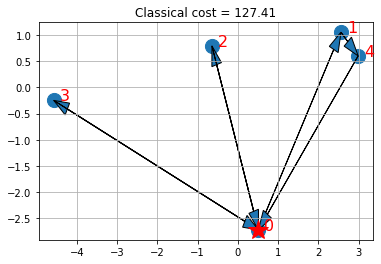

CPU times: user 161 ms, sys: 6.47 ms, total: 167 ms
Wall time: 166 ms


In [ ]:
%%time
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()    

if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

In [ ]:
%%time
# Initialize the problem by defining the parameters
n = 20  # number of nodes + depot (n+1)
K = 5  # number of vehicles

# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()

# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance,n,K)

# Print number of feasible solutions
print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x,classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
    # Print the solution
    print(z)
except: 
    print("CPLEX may be missing.")

Number of feasible solutions = 15504.0
[-0.0, -0.0, -0.0, -0.0, -0.0, 1.0, 1.0, -0.0, 0.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.

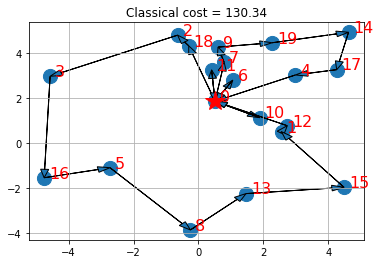

CPU times: user 243 ms, sys: 19.5 ms, total: 262 ms
Wall time: 259 ms


In [ ]:
%%time
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()    

if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

2 1
Number of feasible solutions = 2.0
CPU times: user 4.36 ms, sys: 8.3 ms, total: 12.7 ms
Wall time: 15.8 ms
[1.0, 1.0]


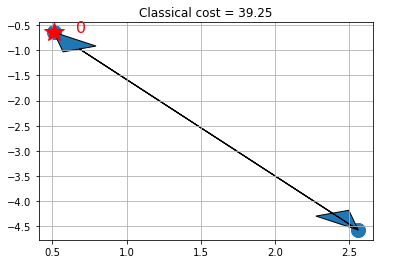

6 3
Number of feasible solutions = 20.0
CPU times: user 50 s, sys: 32.6 ms, total: 50 s
Wall time: 25 s
[1.0, 1.0, -0.0, 1.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, 1.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0]


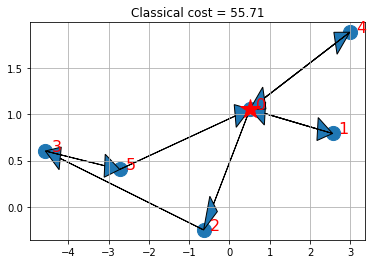

10 5
Number of feasible solutions = 252.0
CPU times: user 38.2 s, sys: 32.9 ms, total: 38.2 s
Wall time: 19 s
[0.0, 1.0, 1.0, 0.0, -0.0, -0.0, 1.0, 1.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


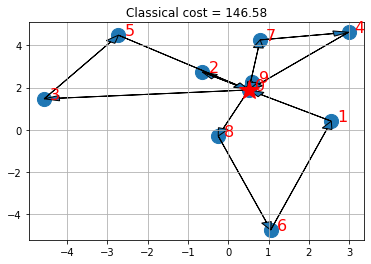

14 7
Number of feasible solutions = 3432.0
CPU times: user 4min 15s, sys: 867 ms, total: 4min 16s
Wall time: 2min 7s
[1.0, -0.0, -0.0, -0.0, 1.0, 0.0, -0.0, 1.0, 1.0, 1.0, -0.0, 1.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0

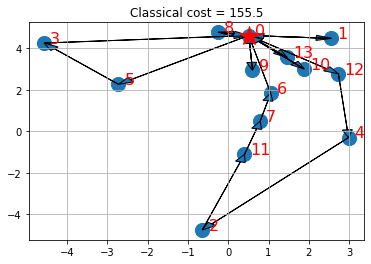

18 9
Number of feasible solutions = 48620.0
CPU times: user 10min 42s, sys: 147 ms, total: 10min 43s
Wall time: 5min 18s
[1.0, 1.0, 1.0, -0.0, -0.0, 0.0, 1.0, 1.0, -0.0, 1.0, -0.0, 1.0, 1.0, 1.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 

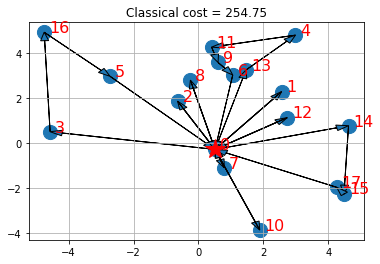

In [ ]:
for K in range(1,10,2):
  #for k in range(1,n):
    n =2*K
    print(n,K)
    initializer = Initializer(n)
    xc,yc,instance = initializer.generate_instance()

    # Instantiate the classical optimizer class
    classical_optimizer = ClassicalOptimizer(instance,n,K)

    # Print number of feasible solutions
    print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

    # Solve the problem in a classical fashion via CPLEX
    x = None
    z = None
    try:
        %time x,classical_cost = classical_optimizer.cplex_solution()
        # Put the solution in the z variable
        z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
        # Print the solution
        print(z)
    except: 
        print("CPLEX may be missing.")
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')


3 2
Number of feasible solutions = 3.0
CPU times: user 11.4 ms, sys: 5.23 ms, total: 16.6 ms
Wall time: 17 ms
[1.0, 1.0, 1.0, 0.0, 1.0, 0.0]


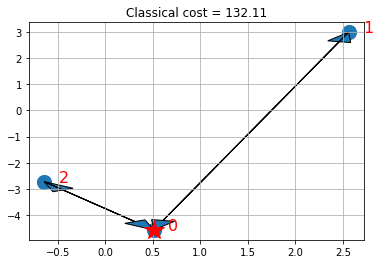

4 2
Number of feasible solutions = 6.0
CPU times: user 17.7 ms, sys: 1.38 ms, total: 19.1 ms
Wall time: 17.8 ms
[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]


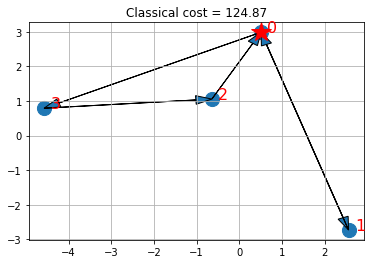

4 3
Number of feasible solutions = 4.0
CPU times: user 7.63 ms, sys: 4.61 ms, total: 12.2 ms
Wall time: 35.7 ms
[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]


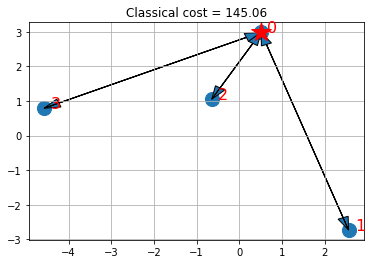

5 2
Number of feasible solutions = 10.0
CPU times: user 198 ms, sys: 25.9 ms, total: 223 ms
Wall time: 118 ms
[0.0, 1.0, 0.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, 1.0, -0.0, -0.0]


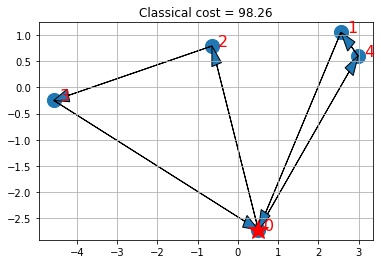

5 3
Number of feasible solutions = 10.0
CPU times: user 54.1 ms, sys: 5.01 ms, total: 59.2 ms
Wall time: 56.4 ms
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


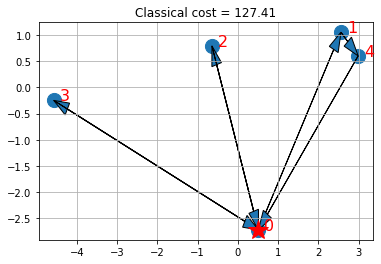

5 4
Number of feasible solutions = 5.0
CPU times: user 8.14 ms, sys: 4.66 ms, total: 12.8 ms
Wall time: 14.4 ms
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


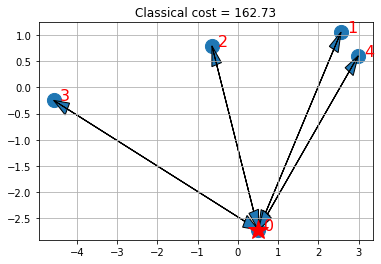

6 2
Number of feasible solutions = 15.0
CPU times: user 21.1 s, sys: 0 ns, total: 21.1 s
Wall time: 10.5 s
[1.0, 1.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, 1.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0]


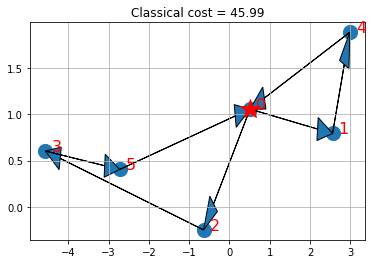

6 3
Number of feasible solutions = 20.0
CPU times: user 42 s, sys: 3.72 ms, total: 42 s
Wall time: 21 s
[1.0, 1.0, -0.0, 1.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, 1.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0]


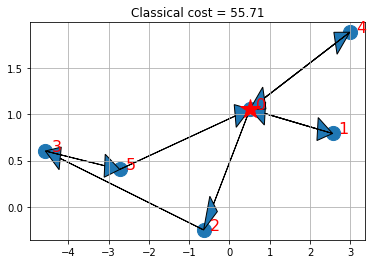

6 4
Number of feasible solutions = 15.0
CPU times: user 18.5 ms, sys: 30 µs, total: 18.6 ms
Wall time: 16.9 ms
[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


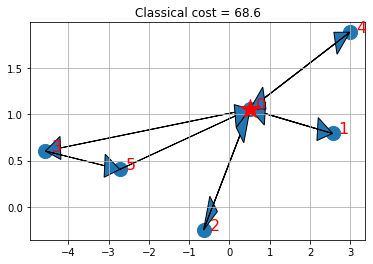

6 5
Number of feasible solutions = 6.0
CPU times: user 12.5 ms, sys: 38 µs, total: 12.6 ms
Wall time: 13.8 ms
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


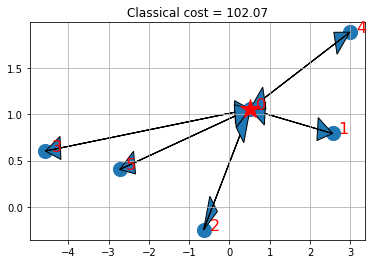

7 2
Number of feasible solutions = 21.0
CPU times: user 46.1 s, sys: 10.3 ms, total: 46.2 s
Wall time: 23.1 s
[1.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 1.0, 1.0, -0.0, 0.0, 0.0, -0.0, -0.0, 1.0, 0.0, -0.0, -0.0, 0.0, -0.0]


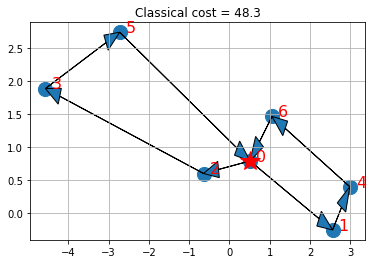

7 3
Number of feasible solutions = 35.0
CPU times: user 18.5 s, sys: 1.48 ms, total: 18.5 s
Wall time: 9.25 s
[1.0, 1.0, -0.0, 0.0, -0.0, 1.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, 1.0, 0.0, -0.0, -0.0, -0.0, 0.0, 1.0, -0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0]


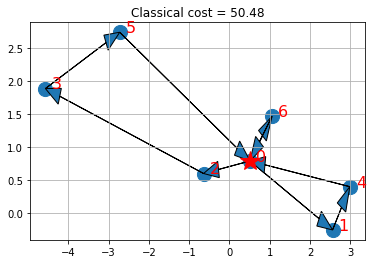

7 4
Number of feasible solutions = 35.0
CPU times: user 214 ms, sys: 4.31 ms, total: 219 ms
Wall time: 97 ms
[1.0, 1.0, -0.0, 1.0, 0.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0]


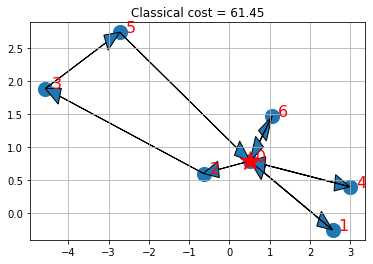

7 5
Number of feasible solutions = 21.0
CPU times: user 10 ms, sys: 12 ms, total: 22 ms
Wall time: 17.7 ms
[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0]


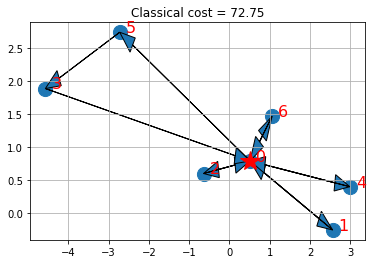

7 6
Number of feasible solutions = 7.0
CPU times: user 5.01 ms, sys: 7.85 ms, total: 12.9 ms
Wall time: 12.5 ms
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


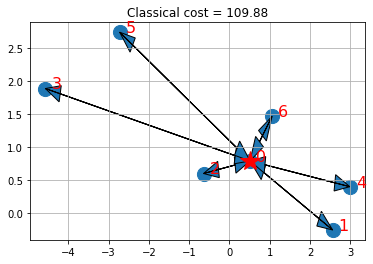

8 2
Number of feasible solutions = 28.0
CPU times: user 1min 9s, sys: 5.17 ms, total: 1min 9s
Wall time: 34.9 s
[1.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0, 0.0, 1.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0]


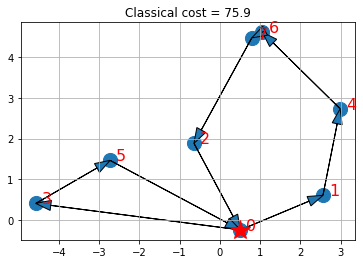

8 3
Number of feasible solutions = 56.0
CPU times: user 1min 57s, sys: 37.9 ms, total: 1min 57s
Wall time: 58.9 s
[1.0, 1.0, 1.0, 0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 1.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0]


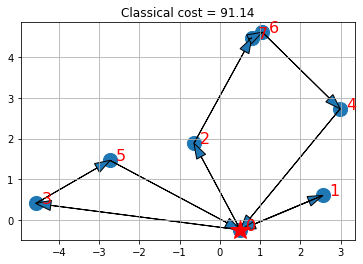

8 4
Number of feasible solutions = 70.0
CPU times: user 29.1 s, sys: 12 ms, total: 29.1 s
Wall time: 14.5 s
[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 1.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0]


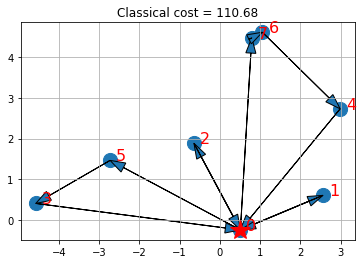

8 5
Number of feasible solutions = 56.0
CPU times: user 6.66 s, sys: 8.22 ms, total: 6.67 s
Wall time: 3.32 s
[1.0, 1.0, -0.0, 1.0, 1.0, 1.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0]


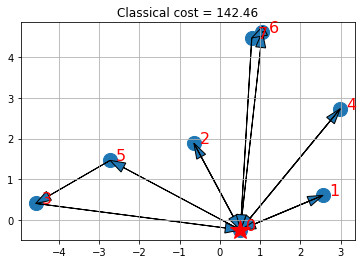

8 6
Number of feasible solutions = 28.0
CPU times: user 17.6 ms, sys: 3.99 ms, total: 21.6 ms
Wall time: 18.5 ms
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


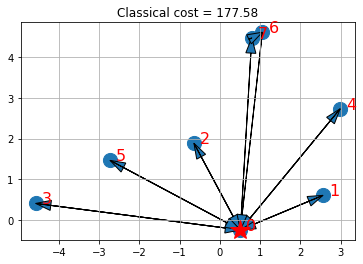

8 7
Number of feasible solutions = 8.0
CPU times: user 8.6 ms, sys: 4.01 ms, total: 12.6 ms
Wall time: 13.7 ms
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


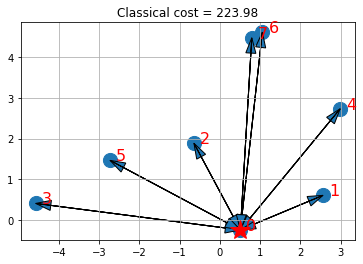

9 2
Number of feasible solutions = 36.0
CPU times: user 42 s, sys: 11.6 ms, total: 42 s
Wall time: 21 s
[-0.0, 0.0, -0.0, 1.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, 0.0, -0.0]


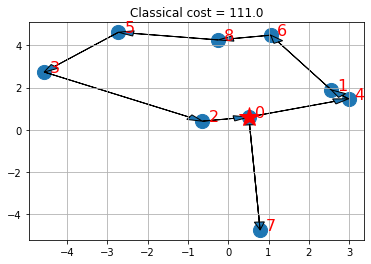

9 3
Number of feasible solutions = 84.0
CPU times: user 2min 30s, sys: 36.9 ms, total: 2min 30s
Wall time: 1min 14s
[0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, 0.0, -0.0]


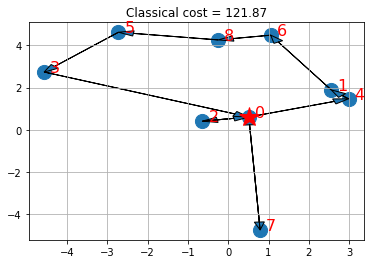

9 4
Number of feasible solutions = 126.0
CPU times: user 9.21 s, sys: 4.03 ms, total: 9.21 s
Wall time: 4.59 s
[1.0, 1.0, 1.0, 0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0]


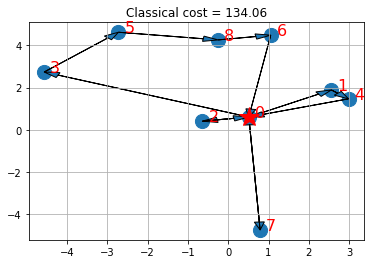

9 5
Number of feasible solutions = 126.0
CPU times: user 3.17 s, sys: 0 ns, total: 3.17 s
Wall time: 1.6 s
[1.0, 1.0, 1.0, 1.0, -0.0, 0.0, 1.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 1.0, -0.0]


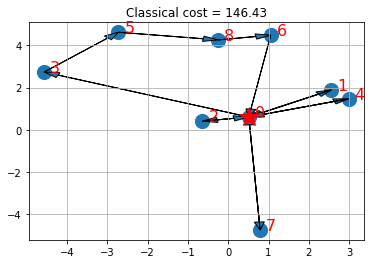

9 6
Number of feasible solutions = 84.0
CPU times: user 191 ms, sys: 4.04 ms, total: 195 ms
Wall time: 94.2 ms
[1.0, 1.0, 0.0, 1.0, -0.0, 1.0, 1.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0]


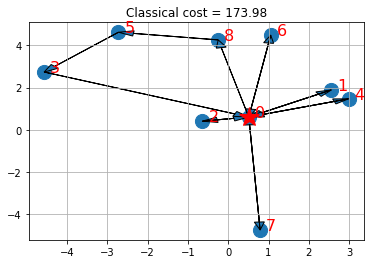

9 7
Number of feasible solutions = 36.0
CPU times: user 73.1 ms, sys: 4.04 ms, total: 77.1 ms
Wall time: 84.6 ms
[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


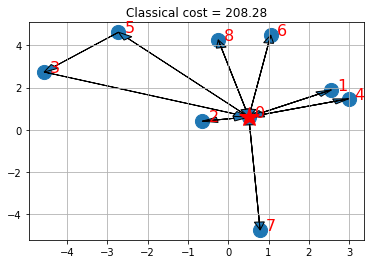

9 8
Number of feasible solutions = 9.0
CPU times: user 9.5 ms, sys: 3.87 ms, total: 13.4 ms
Wall time: 14.7 ms
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


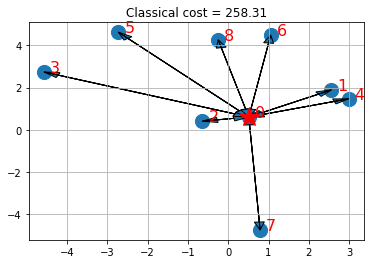

In [ ]:
for n in range(2,10,1):
    for K in range(2,n):
    
        print(n,K)
        initializer = Initializer(n)
        xc,yc,instance = initializer.generate_instance()

        # Instantiate the classical optimizer class
        classical_optimizer = ClassicalOptimizer(instance,n,K)

        # Print number of feasible solutions
        print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

        # Solve the problem in a classical fashion via CPLEX
        x = None
        z = None
        try:
            %time x,classical_cost = classical_optimizer.cplex_solution()
            # Put the solution in the z variable
            z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
            # Print the solution
            print(z)
        except: 
            print("CPLEX may be missing.")
        visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')